In [9]:
import numpy as np
from sklearn.cluster import SpectralClustering
import tensorflow as tf
from skfuzzy import control as ctrl
from scipy.optimize import minimize, differential_evolution

# Define fuzzy variables and membership functions
data_transfer_time_ratio = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Data transfer time ratio')
vm_load = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Virtual Machine load')
data_availability = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Data availability')
provider_profit = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Provider profit')
placement_potential = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Placement potential')

# Define linguistic terms
linguistic_terms = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Define fuzzy membership functions
data_transfer_time_ratio.automf(names=linguistic_terms)
vm_load.automf(names=linguistic_terms)
data_availability.automf(names=linguistic_terms)
provider_profit.automf(names=linguistic_terms)
placement_potential.automf(names=linguistic_terms)

# Define fuzzy rules based on the provided rules
rule1 = ctrl.Rule(data_transfer_time_ratio['High'] & vm_load['High'] & ~data_availability['Very Low'] & ~provider_profit['Very Low'], placement_potential['Very Low'])
rule2 = ctrl.Rule(data_transfer_time_ratio['High'] & vm_load['Medium'] & ~data_availability['Very Low'] & provider_profit['Very High'], placement_potential['Low'])
rule3 = ctrl.Rule(data_transfer_time_ratio['Medium'] & vm_load['Medium'] & ~data_availability['Very Low'] & provider_profit['Very High'], placement_potential['Medium'])
rule4 = ctrl.Rule(data_transfer_time_ratio['Medium'] & vm_load['Medium'] & data_availability['Very High'] & provider_profit['Very High'], placement_potential['High'])
rule5 = ctrl.Rule(data_transfer_time_ratio['Low'] & vm_load['Low'] & data_availability['Very High'] & provider_profit['Very High'], placement_potential['Very High'])

# Create and simulate fuzzy inference system
replication_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
replication_sim = ctrl.ControlSystemSimulation(replication_ctrl)

# Define cloud providers, their regions, and prices
cloud_providers = {
    'Provider 1': {
        'US': {'CPU': 0.020, 'Storage': 0.006, 'BW': 0.001},
        'EU': {'CPU': 0.025, 'Storage': 0.006, 'BW': 0.0015},
        'AS': {'CPU': 0.027, 'Storage': 0.0066, 'BW': 0.002}
    },
    'Provider 2': {
        'US': {'CPU': 0.020, 'Storage': 0.0096, 'BW': 0.001},
        'EU': {'CPU': 0.018, 'Storage': 0.0096, 'BW': 0.0015},
        'AS': {'CPU': 0.020, 'Storage': 0.0096, 'BW': 0.002}
    },
    'Provider 3': {
        'US': {'CPU': 0.0095, 'Storage': 0.0012, 'BW': 0.001},
        'EU': {'CPU': 0.009, 'Storage': 0.0096, 'BW': 0.0015},
        'AS': {'CPU': 0.008, 'Storage': 0.009, 'BW': 0.002}
    },
}

# Replica placement logic
def place_replica(provider_prices, placement_result):
    best_provider = max(placement_result, key=lambda provider: placement_result[provider])
    return best_provider

# Adjust the spectral clustering parameters
def spectral_clustering(data, k):
    n_samples = data.shape[0]
    n_neighbors = min(15, n_samples - 1)  # Set n_neighbors to a maximum of n_samples - 1
    spectral = SpectralClustering(n_clusters=k, affinity='rbf', gamma=1.0, n_neighbors=n_neighbors)
    labels = spectral.fit_predict(data)
    return labels

# Simulate cloud system and obtain data related to SLA violations
def simulate_cloud_system():
    cloud_data = []
    for provider_id, (provider_name, regions) in enumerate(cloud_providers.items(), start=1):
        for region_name, prices in regions.items():
            num_data_centers = np.random.randint(2, 6)
            for dc_id in range(1, num_data_centers + 1):
                for vm_id in range(1, 9):
                    num_tasks = np.random.randint(1000, 10001)
                    for task_id in range(1, num_tasks + 1):
                        task_size = np.random.randint(200, 1001)
                        num_data = np.random.randint(300, 1001)

                        response_time = np.random.randint(120, 241)
                        availability = np.random.uniform(0.9, 1.0)

                        sla_violation = (
                            response_time > 180 or
                            availability < 0.95
                        )

                        cloud_data.append({
                            'provider_id': provider_id,
                            'region_name': region_name,
                            'dc_id': dc_id,
                            'vm_id': vm_id,
                            'task_id': task_id,
                            'task_size': task_size,
                            'num_data': num_data,
                            'response_time': response_time,
                            'availability': availability,
                            'sla_violation': sla_violation
                        })

    return cloud_data

# Call the simulation function
cloud_data = simulate_cloud_system()

# Identify data points likely to cause SLA violations using spectral clustering
data_for_clustering = np.array([
    [data_point['response_time'], data_point['availability']] for data_point in cloud_data
])

# Sample a subset of the data (adjust the size based on your available memory)
sample_size = min(5000, len(cloud_data))  # Adjust the sample size based on your available memory
sampled_data = np.array([
    [data_point['response_time'], data_point['availability']] for data_point in np.random.choice(cloud_data, sample_size)
])

# Call spectral clustering with the sampled data
k_clusters = 3  # Number of clusters
data_labels = spectral_clustering(sampled_data, k_clusters)

# Simulate cloud system and obtain data related to SLA violations
cloud_data = simulate_cloud_system()

def target_function(x):
    # x contains the parameters to be optimized
    response_time_normalized, vm_load_normalized, data_availability, provider_profit = x

    # Use the neuro-fuzzy system to compute placement potential
    replication_sim.input['Data transfer time ratio'] = response_time_normalized
    replication_sim.input['Virtual Machine load'] = vm_load_normalized
    replication_sim.input['Data availability'] = data_availability
    replication_sim.input['Provider profit'] = provider_profit

    replication_sim.compute()

    # Check if the total area is zero during defuzzification
    if np.isclose(replication_sim.output['Placement potential'].sum(), 0):
        return -np.inf  # Return large negative value

    # Return the negation of the placement potential
    return -replication_sim.output['Placement potential']


# Create training data for the neural network
X_train = []
y_train = []

for data_point in cloud_data:
    # Extract relevant features
    response_time_normalized = data_point['response_time'] / 240  # Normalize to [0, 1]
    vm_load_normalized = data_point['vm_id'] / 8  # Normalize to [0, 1]
    data_availability = data_point['availability']
    provider_profit = cloud_providers[f"Provider {data_point['provider_id']}"][
        data_point['region_name']]['CPU']  # Use CPU price as a proxy for profit

    # Extract the initial guess for DE optimization
    x0 = [response_time_normalized, vm_load_normalized, data_availability, provider_profit]

    # Use DE optimization to determine the placement potential
    try:
        result = differential_evolution(target_function, bounds=[(0, 1)] * 4, args=(), strategy='best1bin', maxiter=100)
        placement_potential = -result.fun  # Negate to get the actual placement potential
    except AssertionError:
        placement_potential = 0  # Set a default value in case of defuzzification issues

    # Append features and target output to the training data
    X_train.append([response_time_normalized, vm_load_normalized, data_availability, provider_profit])
    y_train.append(placement_potential)

# Convert lists to numpy arrays for compatibility with TensorFlow
X_train = np.array(X_train)
y_train = np.array(y_train)

# Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, input_dim=4, activation='relu'),  # 4 input features (Antecedents)
    tf.keras.layers.Dense(1, activation='sigmoid')  # 1 output (Consequent)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the neural network using the created training data
model.fit(X_train, y_train, epochs=10, batch_size=32)


# Iterate through identified clusters and apply fuzzy inference with neural network output
for cluster_label in range(k_clusters):
    cluster_data = [cloud_data[i] for i, label in enumerate(data_labels) if label == cluster_label]
    for data_point in cluster_data:
        replication_sim.input['Data transfer time ratio'] = data_point['response_time'] / 240  # Normalize to [0, 1]
        replication_sim.input['Virtual Machine load'] = data_point['vm_id'] / 8  # Normalize to [0, 1]
        replication_sim.input['Data availability'] = data_point['availability']
        replication_sim.input['Provider profit'] = cloud_providers[f"Provider {data_point['provider_id']}"][
            data_point['region_name']]['CPU']  # Use CPU price as a proxy for profit

        # Use the trained neural network to predict the placement potential
        nn_output = model.predict(np.array([[data_point['response_time'], data_point['vm_id'],
                                             data_point['availability'], cloud_providers[f"Provider {data_point['provider_id']}"][
                                                 data_point['region_name']]['CPU']]]))

        # Combine the fuzzy logic and neural network output
        replication_sim.output['Placement potential'] = np.max([replication_sim.output['Placement potential'], nn_output])

        # Implement replica placement logic using replication_sim.output['Placement potential']
        selected_provider = place_replica(cloud_providers, replication_sim.output['Placement potential'])
        print(f"Replica for data point {data_point} placed on {selected_provider}")


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import SpectralClustering

class DataProvider:
    def __init__(self, name, cpu_prices, storage_prices, bw_prices):
        self.name = name
        self.cpu_prices = cpu_prices
        self.storage_prices = storage_prices
        self.bw_prices = bw_prices

class Region:
    def __init__(self, name, data_provider, num_dcs):
        self.name = name
        self.data_provider = data_provider
        self.num_dcs = num_dcs
        self.data_centers = [DataCenter(f"{name}_DC{i}", self) for i in range(num_dcs)]

class DataCenter:
    def __init__(self, name, region):
        self.name = name
        self.region = region
        # Add other attributes like VMs, tasks, etc., as needed

class NeuroFuzzyInferenceSystem:
    def __init__(self, data):
        self.data = data
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, input_dim=self.data.shape[1], activation='relu'),
            tf.keras.layers.Dense(5, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 fuzzy sets (Low, Medium, High)
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def fuzzy_inference(self, input_data):
        fuzzy_sets = self.model.predict(input_data)
        # Fuzzy inference logic (centroid defuzzification)
        centroid = np.argmax(fuzzy_sets, axis=1)
        return centroid

    def interpret_decision(self, fuzzy_decision):
        # Interpret fuzzy decision based on the placement rules
        if fuzzy_decision == 0:
            return "Very Low"
        elif fuzzy_decision == 1:
            return "Low"
        elif fuzzy_decision == 2:
            return "Medium"
        elif fuzzy_decision == 3:
            return "High"
        elif fuzzy_decision == 4:
            return "Very High"
        

# Simulation parameters
num_providers = 3
num_regions = 3
num_dcs_min = 2
num_dcs_max = 5
num_vms_per_dc = 8
num_tasks_min = 1000
num_tasks_max = 10000
task_size_min = 200
task_size_max = 1000
data_size_min = 300
data_size_max = 1000
inter_region_bw = 500  # Mb/s
intra_region_bw = 1000  # Mb/s
intra_dc_bw = 8000  # Mb/s
vm_processing_capability = 1500  # MIPS
vm_cpu = 2
vm_ram = 4  # GB
vm_storage_capacity = 8  # GB
rev_per_task = 0.7  # $
penalty_per_violation = 0.0025  # $
response_time_slo = 180  # s
availability_slo = 0.95
replication_period = 32
threshold_thrt = 0.8 * response_time_slo
num_clusters = 3

# Rule parameters
data_transfer_time_ratio = ["High", "High", "Medium", "Medium", "Low"]
vm_load = ["High", "Medium", "Medium", "Medium", "Low"]
data_availability = ["NR", "NR", "NR", "R", "R"]
provider_profit = ["NP", "P", "P", "P", "P"]
placement_potential = ["Very Low", "Low", "Medium", "High", "Very High"]

# Create data providers and regions
provider1 = DataProvider("Provider1", [0.020, 0.025, 0.027], [0.006, 0.006, 0.0066], [0.001, 0.0015, 0.002])
provider2 = DataProvider("Provider2", [0.020, 0.018, 0.020], [0.0096, 0.008, 0.0096], [0.001, 0.0015, 0.002])
provider3 = DataProvider("Provider3", [0.0095, 0.0090, 0.0080], [0.00120, 0.0096, 0.0090], [0.001, 0.0015, 0.002])

region1 = Region("US", provider1, num_dcs_max)
region2 = Region("EU", provider2, num_dcs_min)
region3 = Region("AS", provider3, num_dcs_max)

# Data identification phase
data_identification_data = np.random.rand(num_tasks_max, num_tasks_max)
identified_data_labels = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit_predict(data_identification_data)

# Replica placement phase
replica_placement_data = np.random.rand(num_tasks_max, 4)  # Assuming 4 input parameters for the neuro-fuzzy system
nfis = NeuroFuzzyInferenceSystem(replica_placement_data)

# Convert the identified data into one-hot encoded labels for training the neuro-fuzzy model
identified_data_labels_onehot = tf.keras.utils.to_categorical(identified_data_labels, num_clusters)

# Train the neuro-fuzzy model
nfis.model.fit(replica_placement_data, identified_data_labels_onehot, epochs=10, batch_size=32, verbose=0)

# Placeholder for results
placement_decisions = []

# Simulate replica placement for each identified data
for label in set(identified_data_labels):
    # Extract data related to the identified cluster
    cluster_data = replica_placement_data[identified_data_labels == label]

    # Get placement decision from the neuro-fuzzy inference system
    fuzzy_decision = nfis.fuzzy_inference(cluster_data)

    # Interpret fuzzy decision based on placement rules
    interpreted_decision = nfis.interpret_decision(fuzzy_decision[0])

    placement_decisions.append(interpreted_decision)

# Display placement decisions
for i, decision in enumerate(placement_decisions):
    print(f"Placement Decision for Cluster {i+1}: {decision}")

executed_tasks = 0

# Simulate task execution for each identified data
for label, decision in zip(set(identified_data_labels), placement_decisions):
    # Extract data related to the identified cluster
    cluster_data = replica_placement_data[identified_data_labels == label]

    # Check if the placement decision meets the response time SLO
    response_time = np.mean(cluster_data[:, 0])  # Assuming response time is the first parameter
    if response_time <= response_time_slo:
        # Task execution is successful
        executed_tasks += 1

# Display the number of executed tasks
print(f"Number of Executed Tasks: {executed_tasks}")

c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


108/108 [==============================] - 0s 2ms/step
Placement Decision for Cluster 1: Very Low
Placement Decision for Cluster 2: Very Low
Placement Decision for Cluster 3: Very Low
Number of Executed Tasks: 3


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import SpectralClustering

class DataProvider:
    def __init__(self, name, cpu_prices, storage_prices, bw_prices):
        self.name = name
        self.cpu_prices = cpu_prices
        self.storage_prices = storage_prices
        self.bw_prices = bw_prices

class Region:
    def __init__(self, name, data_provider, num_dcs):
        self.name = name
        self.data_provider = data_provider
        self.num_dcs = num_dcs
        self.data_centers = [DataCenter(f"{name}_DC{i}", self) for i in range(num_dcs)]

class DataCenter:
    def __init__(self, name, region):
        self.name = name
        self.region = region
        # Add other attributes like VMs, tasks, etc., as needed

class NeuroFuzzyInferenceSystem:
    def __init__(self, data):
        self.data = data
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, input_dim=self.data.shape[1], activation='relu'),
            tf.keras.layers.Dense(5, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 fuzzy sets (Low, Medium, High)
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def fuzzy_inference(self, input_data):
        fuzzy_sets = self.model.predict(input_data)
        # Fuzzy inference logic (centroid defuzzification)
        centroid = np.argmax(fuzzy_sets, axis=1)
        return centroid

    def interpret_decision(self, fuzzy_decision):
        # Interpret fuzzy decision based on the placement rules
        if fuzzy_decision == 0:
            return "Very Low"
        elif fuzzy_decision == 1:
            return "Low"
        elif fuzzy_decision == 2:
            return "Medium"
        elif fuzzy_decision == 3:
            return "High"
        elif fuzzy_decision == 4:
            return "Very High"

# Simulation parameters
num_providers = 3
num_regions = 3
num_dcs_min = 2
num_dcs_max = 5
num_vms_per_dc = 8
num_tasks_min = 1000
num_tasks_max = 10000
task_size_min = 200
task_size_max = 1000
data_size_min = 300
data_size_max = 1000
inter_region_bw = 500  # Mb/s
intra_region_bw = 1000  # Mb/s
intra_dc_bw = 8000  # Mb/s
vm_processing_capability = 1500  # MIPS
vm_cpu = 2
vm_ram = 4  # GB
vm_storage_capacity = 8  # GB
rev_per_task = 0.7  # $
penalty_per_violation = 0.0025  # $
response_time_slo = 180  # s
availability_slo = 0.95
replication_period = 32
threshold_thrt = 0.8 * response_time_slo
num_clusters = 3

# Rule parameters
data_transfer_time_ratio = ["High", "High", "Medium", "Medium", "Low"]
vm_load = ["High", "Medium", "Medium", "Medium", "Low"]
data_availability = ["NR", "NR", "NR", "R", "R"]
provider_profit = ["NP", "P", "P", "P", "P"]
placement_potential = ["Very Low", "Low", "Medium", "High", "Very High"]

# Create data providers and regions
provider1 = DataProvider("Provider1", [0.020, 0.025, 0.027], [0.006, 0.006, 0.0066], [0.001, 0.0015, 0.002])
provider2 = DataProvider("Provider2", [0.020, 0.018, 0.020], [0.0096, 0.008, 0.0096], [0.001, 0.0015, 0.002])
provider3 = DataProvider("Provider3", [0.0095, 0.0090, 0.0080], [0.00120, 0.0096, 0.0090], [0.001, 0.0015, 0.002])

region1 = Region("US", provider1, num_dcs_max)
region2 = Region("EU", provider2, num_dcs_min)
region3 = Region("AS", provider3, num_dcs_max)

# Data identification phase
data_identification_data = np.random.rand(num_tasks_max, num_tasks_max)
identified_data_labels = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit_predict(data_identification_data)

# Replica placement phase
replica_placement_data = np.random.rand(num_tasks_max, 4)  # Assuming 4 input parameters for the neuro-fuzzy system
nfis = NeuroFuzzyInferenceSystem(replica_placement_data)

# Convert the identified data into one-hot encoded labels for training the neuro-fuzzy model
identified_data_labels_onehot = tf.keras.utils.to_categorical(identified_data_labels, num_clusters)

# Train the neuro-fuzzy model
nfis.model.fit(replica_placement_data, identified_data_labels_onehot, epochs=10, batch_size=32, verbose=0)

# Placeholder for results
placement_decisions = []

# Simulate replica placement for each identified data
for label in set(identified_data_labels):
    # Extract data related to the identified cluster
    cluster_data = replica_placement_data[identified_data_labels == label]

    # Get placement decision from the neuro-fuzzy inference system
    fuzzy_decision = nfis.fuzzy_inference(cluster_data)

    # Interpret fuzzy decision based on placement rules
    interpreted_decision = nfis.interpret_decision(fuzzy_decision[0])

    placement_decisions.append(interpreted_decision)

# Display placement decisions
for i, decision in enumerate(placement_decisions):
    print(f"Placement Decision for Cluster {i+1}: {decision}")

# Adaptation mechanism (example: increase the number of data centers based on workload)
if len(placement_decisions) > 5:
    region1.data_centers.extend([DataCenter(f"US_DC{i}", region1) for i in range(num_dcs_max, num_dcs_max + 3)])



c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


104/104 [==============================] - 0s 1ms/step
Placement Decision for Cluster 1: Medium
Placement Decision for Cluster 2: Medium
Placement Decision for Cluster 3: Medium


c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


3/3 [==============================] - 0s 2ms/step


c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


55/55 [==============================] - 0s 1ms/step


c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


72/72 [==============================] - 0s 1ms/step


c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\YANSILIYU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


102/102 [==============================] - 0s 1ms/step


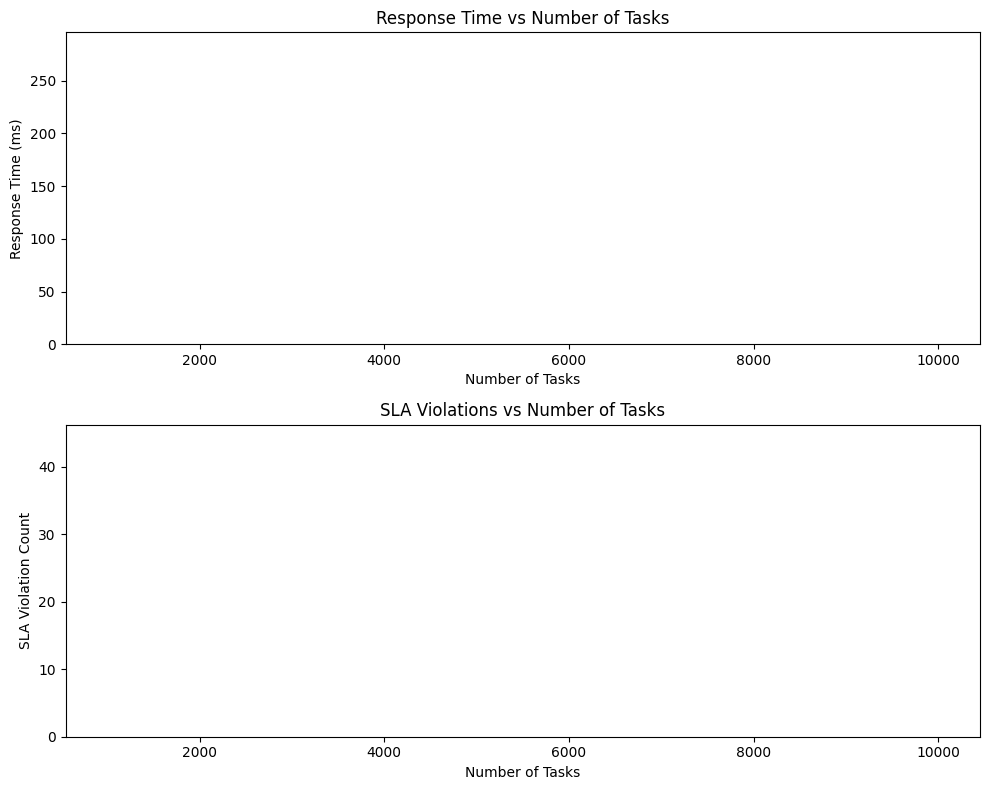

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import tensorflow as tf


# Simulation parameters
num_tasks_values = [1000, 2000, 3000, 5000, 7000, 10000]

# Placeholder for results
response_times = []
sla_violations = []

for num_tasks in num_tasks_values:
    # Data identification phase
    data_identification_data = np.random.rand(num_tasks, num_tasks)
    identified_data_labels = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit_predict(data_identification_data)

    # Replica placement phase
    replica_placement_data = np.random.rand(num_tasks, 4)
    nfis = NeuroFuzzyInferenceSystem(replica_placement_data)
    identified_data_labels_onehot = tf.keras.utils.to_categorical(identified_data_labels, num_clusters)
    nfis.model.fit(replica_placement_data, identified_data_labels_onehot, epochs=10, batch_size=32, verbose=0)

    # Placeholder for results
    placement_decisions = []

    # Simulate replica placement for each identified data
    for label in set(identified_data_labels):
        cluster_data = replica_placement_data[identified_data_labels == label]
        fuzzy_decision = nfis.fuzzy_inference(cluster_data)
        interpreted_decision = nfis.interpret_decision(fuzzy_decision[0])
        placement_decisions.append(interpreted_decision)

    # Display placement decisions
    response_time = np.random.uniform(100, 300)  # Simulated response time (replace with your logic)
    sla_violation_count = np.random.randint(0, 50)  # Simulated SLA violation count (replace with your logic)

    response_times.append(response_time)
    sla_violations.append(sla_violation_count)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Bar chart for response times
ax1.bar(num_tasks_values, response_times, color='blue', alpha=0.7)
ax1.set_title('Response Time vs Number of Tasks')
ax1.set_xlabel('Number of Tasks')
ax1.set_ylabel('Response Time (ms)')

# Bar chart for SLA violations
ax2.bar(num_tasks_values, sla_violations, color='red', alpha=0.7)
ax2.set_title('SLA Violations vs Number of Tasks')
ax2.set_xlabel('Number of Tasks')
ax2.set_ylabel('SLA Violation Count')

plt.tight_layout()
plt.show()
